<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/10_Lab_9_Epipolar_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**

<p align = 'justify'>In Lecture 9 we looked at estimating the fundamental 
matrix between two images. In this lab you will write a program to process a video sequence, track the features, and calculate the epipolar geometry for
selected frames. You will need to adapt and extend the KLT feature tracking of Lab06 to process the video bananas.mp4 available on Canvas.</p>


**Task 1**

<p align = 'justify'>Adapt your KLT tracking implementation from the previous Lab06 to track features across the whole image sequence of the file bananas.mp4. Make sure that there is sufficient feature overlap between the 50th and the 100th frame of the sequence.</p>

Task 2

<p align = 'justify'>Use the extracted feature tracks to estimate the fundamental matrix between the 50th and  the 100th frame using the Direct Linear Transformation (DLT) algorithm.</p>

**Task 3**

<p align = 'justify'>Use the fundamental matrix calculated in task 2 to determine the epipoles in both images. Extract the 50th and 100th frame from the image sequence and draw the epipoles into these images.</p>

**Task 4**

<p align = 'justify'>Calculate the epipolar line for the pixel in the centre of the 50th frame. Draw this epipolar line into the 100th frame.</p>

In [10]:
import cv2
import numpy as np

In [11]:
from google.colab.patches import cv2_imshow

In [12]:
!wget https://github.com/raj-vijay/mv/raw/master/images/bananas.mp4

--2021-05-02 13:41:37--  https://github.com/raj-vijay/mv/raw/master/images/bananas.mp4
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raj-vijay/mv/master/images/bananas.mp4 [following]
--2021-05-02 13:41:38--  https://raw.githubusercontent.com/raj-vijay/mv/master/images/bananas.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6594680 (6.3M) [application/octet-stream]
Saving to: ‘bananas.mp4’

bananas.mp4         100%[===================>]   6.29M  19.1MB/s    in 0.3s    

2021-05-02 13:41:39 (19.1 MB/s) - ‘bananas.mp4’ saved [6594680/6594680]



In [13]:
def get_tracks(filename, stop_at_frame):
    camera = cv2.VideoCapture(filename)

    # initialise features to track
    while camera.isOpened():
        ret,img= camera.read()        
        if ret:
            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
            p0 = cv2.goodFeaturesToTrack(new_img, 200, 0.3, 7)                                    
            break    

    # initialise tracks
    index = np.arange(len(p0))
    tracks = {}
    for i in range(len(p0)):
        tracks[index[i]] = {0:p0[i]}
                
    frame = 0
    while camera.isOpened():
        ret,img= camera.read()                 
        if not ret:
            break

        frame += 1
        
        if frame>stop_at_frame:
            break

        old_img = new_img
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        

        # calculate optical flow
        if len(p0)>0: 
            p1, st, err  = cv2.calcOpticalFlowPyrLK(old_img, new_img, p0, None)                                    
            
            # visualise points
            for i in range(len(st)):
                if st[i]:
                    cv2.circle(img, (int(p1[i,0,0]),int(p1[i,0,1])), 2, (0,0,255), 2)
                    cv2.line(img, (int(p0[i,0,0]),int(p0[i,0,1])), (int(p0[i,0,0]+(p1[i][0,0]-p0[i,0,0])*5),int(p0[i,0,1]+(p1[i][0,1]-p0[i,0,1])*5)), (0,0,255), 2)            
            
            p0 = p1[st==1].reshape(-1,1,2)            
            index = index[st.flatten()==1]
                
            
        # refresh features, if too many lost
        if len(p0)<100:
            new_p0 = cv2.goodFeaturesToTrack(new_img, 200-len(p0), 0.3, 7)
            for i in range(len(new_p0)):
                if np.min(np.linalg.norm((p0 - new_p0[i]).reshape(len(p0),2),axis=1))>10:
                    p0 = np.append(p0,new_p0[i].reshape(-1,1,2),axis=0)
                    index = np.append(index,np.max(index)+1)

        # update tracks
        for i in range(len(p0)):
            if index[i] in tracks:
                tracks[index[i]][frame] = p0[i]
            else:
                tracks[index[i]] = {frame: p0[i]}

        # visualise last frames of active tracks
        for i in range(len(index)):
            for f in range(frame-20,frame):
                if (f in tracks[index[i]]) and (f+1 in tracks[index[i]]):
                    cv2.line(img,
                             (int(tracks[index[i]][f][0,0]),int(tracks[index[i]][f][0,1])),
                             (int(tracks[index[i]][f+1][0,0]),int(tracks[index[i]][f+1][0,1])), 
                             (0,255,0), 1)

    camera.release()
        
    return tracks, frame

In [14]:
def extract_frames(filename, frames):
    result = {}
    camera = cv2.VideoCapture(filename)
    last_frame = max(frames)
    frame=0
    while camera.isOpened():
        ret,img= camera.read()        
        if not ret:
            break
        if frame in frames:
            result[frame] = img        
        frame += 1
        if frame>last_frame:
            break

    return result

In [15]:
def calculate_fundamental_matrix(tracks, frame1, frame2, width, height):
    correspondences = []
    for track in tracks:
        if (frame1 in tracks[track]) and (frame2 in tracks[track]):
            x1 = [tracks[track][frame1][0,0],tracks[track][frame1][0,1],1]
            x2 = [tracks[track][frame2][0,0],tracks[track][frame2][0,1],1]
            correspondences.append((np.array(x1), np.array(x2)))

    A = np.zeros((0,9))
    for x1,x2 in correspondences:
        ai = np.kron(x1.T,x2.T)
        A = np.append(A,[ai],axis=0)
            
    U,S,V = np.linalg.svd(A)    
    F = V[8,:].reshape(3,3).T

    U,S,V = np.linalg.svd(F)
    F = np.matmul(U,np.matmul(np.diag([S[0],S[1],0]),V))
    
    return F

In [16]:
def calculate_epipoles(F):
    U,S,V = np.linalg.svd(F)    
    e1 = V[2,:]

    U,S,V = np.linalg.svd(F.T)    
    e2 = V[2,:]

    return e1,e2    

In [17]:
def calculate_epipolar_line(F, x, width, height):
    l = np.matmul(F, x)
    l1 = np.cross([0,0,1],[width-1,0,1])
    l2 = np.cross([0,0,1],[0,height-1,1])
    l3 = np.cross([width-1,0,1],[width-1,height-1,1])
    l4 = np.cross([0,height-1,1],[width-1,height-1,1])
    x1 = np.cross(l,l1)
    x2 = np.cross(l,l2)
    x3 = np.cross(l,l3)
    x4 = np.cross(l,l4)
    x1 /= x1[2]
    x2 /= x2[2]
    x3 /= x3[2]
    x4 /= x4[2]
    result = []
    if (x1[0]>=0) and (x1[0]<=width):
        result.append(x1)
    if (x2[1]>=0) and (x2[1]<=height):
        result.append(x2)
    if (x3[1]>=0) and (x3[1]<=height):
        result.append(x3)
    if (x4[0]>=0) and (x4[0]<=width):
        result.append(x4)
    return result[0],result[1]

In [18]:
def main():
    f1 = 50
    f2 = 100
    tracks, frames = get_tracks("bananas.mp4", f2)

    images = extract_frames("bananas.mp4", [f1,f2])
    width = images[f1].shape[1]
    height = images[f1].shape[0]
             
    F = calculate_fundamental_matrix(tracks, f1, f2, width, height)
    
    e1,e2 = calculate_epipoles(F)
    print(e1/e1[2])    
    print(e2/e2[2])    
    
    cv2.circle(images[f1], (int(e1[0]/e1[2]),int(e1[1]/e1[2])), 3, (0,0,255), 2)
    cv2.circle(images[f2], (int(e2[0]/e2[2]),int(e2[1]/e2[2])), 3, (0,0,255), 2)

    x = np.array([0.5*width, 
                  0.5*height,
                  1])
    x1, x2 = calculate_epipolar_line(F, x, width, height)
    
    cv2.circle(images[f1], (int(x[0]/x[2]),int(x[1]/x[2])), 3, (0,255,0), 2)
    cv2.line(images[f2], (int(x1[0]/x1[2]),int(x1[1]/x1[2])), (int(x2[0]/x2[2]),int(x2[1]/x2[2])), (0,255,0), 2)
    
    print("Image 1")
    cv2_imshow(images[f1])
    print("Image 2")
    cv2_imshow(images[f2])

    cv2.waitKey(0)
    cv2.destroyAllWindows()

[511.38920139 401.95630036   1.        ]
[447.81479677 168.68205679   1.        ]
Image 1


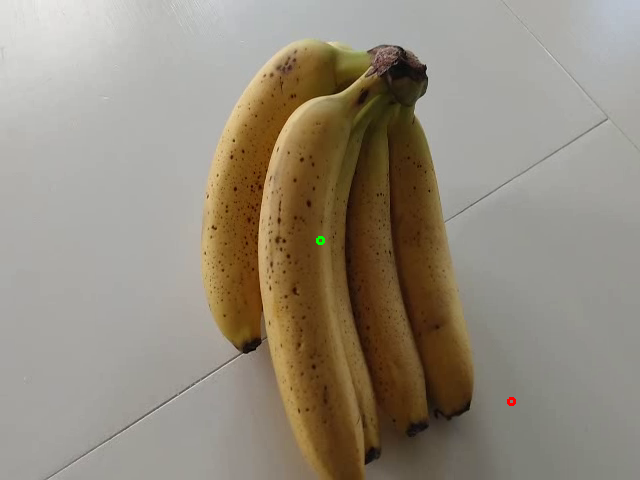

Image 2


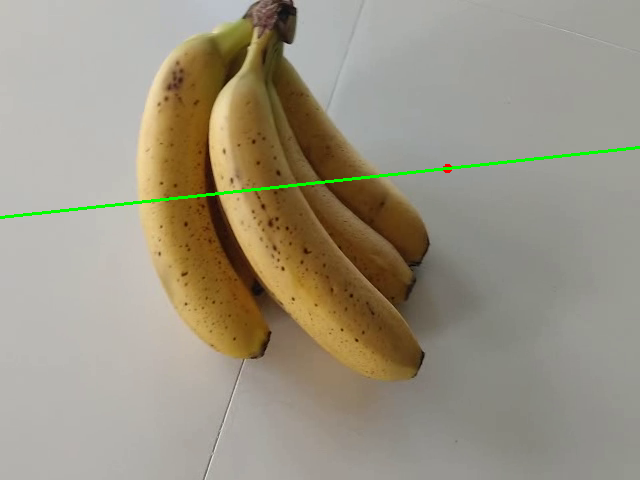

In [19]:
main()